In [56]:
import os
from dotenv import load_dotenv
import mysql.connector as sql

import numpy as np
import pandas as pd
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### 1. Data Loading from Database

In [57]:
load_dotenv()
MySQL_SECRET = os.getenv("MySQL_ROOT_PASS")

In [58]:
### Connect to MySQL
db_conn = sql.connect(
    host="localhost",
    user="root",
    password=MySQL_SECRET,
    use_pure=True
)

print("Connected:", db_conn.is_connected())

Connected: True


In [59]:
cursor = db_conn.cursor()
cursor.execute(
    """
    USE bike_share;
    """
)
cursor.close()

True

### 2. Spatial Analysis

#### 2.1 Location of all 'Active' bike stations
This section we visualize 'Active' bike stations where it is not a virtual station and the spatial information is available.

In [60]:
def get_activeStations(conn):
    db_cursor = conn.cursor()
    db_cursor.execute(
        """
        SELECT
            station_id,
            name,
            region,
            latitude,
            longitude,
            live_date
        FROM stations
        WHERE 
            status LIKE 'active' AND
            (latitude IS NOT NULL AND longitude IS NOT NULL);
        """
    )
    rows = db_cursor.fetchall()
    db_cursor.close()
    active_stations = pd.DataFrame(
        rows, columns=["station_id", "name", "region", "latitude", "longitude", "live_date"]
    )
    return active_stations

In [61]:
active_stations = get_activeStations(db_conn)

In [62]:
active_stations.head(5)

,station_id,name,region,latitude,longitude,live_date
0,3005,7th & Flower,DTLA,34.0485000,-118.2585370,2016-07-07
1,3006,Olive & 8th,DTLA,34.0455400,-118.2566680,2016-07-07
2,3007,5th & Grand,DTLA,34.0504800,-118.2545930,2016-07-07
3,3008,Figueroa & 9th,DTLA,34.0466120,-118.2627330,2016-07-07
4,3010,11th & Maple,DTLA,34.0370480,-118.2548680,2016-07-10


In [63]:
def plot_stations_map(stations_df):
    clone_df = stations_df.copy()
    map_center = [clone_df["latitude"].mean(), clone_df["longitude"].mean()]
    
    ## Folium Map
    station_map = folium.Map(
        location=map_center, 
        control_scale=True,
        zoom_start=10
    )

    ## Add Markers
    for idx, row in clone_df.iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=f"""
            {row["name"]} ({row["region"]}) <br>
            Live Date: {row["live_date"]}
            """,
            tooltip=row["name"],
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(station_map)

    return station_map

In [64]:
stations_map = plot_stations_map(active_stations)
stations_map  # If using in a Jupyter Notebook

In [65]:
stations_map.save(".\\assets\\maps\\stations_map.html")

#### 2.2 Start Station Hotspots From 2022 to 2024

In [66]:
def get_startStationCounts(conn):
    db_cursor = conn.cursor()
    db_cursor.execute(
        """
        WITH start_stations AS (
            SELECT 
    		start_station,
    		COUNT(*) AS number_of_trips
    	FROM trips
    	GROUP BY start_station
     )
     SELECT
         s.station_id AS station_id,
         s.name AS name,
         s.region AS region,
         s.latitude AS latitude,
         s.longitude AS longitude,
         s.live_date AS live_date,
         ss.number_of_trips AS ntrips
    FROM start_stations AS ss
    LEFT JOIN stations AS s
        ON ss.start_station = s.station_id
    WHERE
        s.status LIKE 'Active' AND 
        (s.latitude IS NOT NULL AND s.longitude IS NOT NULL)
    ORDER BY
        ntrips DESC;
        """
    )
    rows = db_cursor.fetchall()
    db_cursor.close()
    start_station_count = pd.DataFrame(
        rows, columns=["station_id", "name", "region", "latitude", "longitude", "live_date", "ntrips"]
    )
    return start_station_count

In [67]:
start_station_counts = get_startStationCounts(db_conn)

In [68]:
start_station_counts.head(5)

,station_id,name,region,latitude,longitude,live_date,ntrips
0,4214,Ocean Front Walk & Navy,Westside,33.9955600,-118.4815520,2017-07-07,62074
1,4215,Downtown Santa Monica E Line Station,Westside,34.0143090,-118.4913410,2017-07-07,44940
2,4210,Ocean Front Walk & North Venice,Westside,33.9843410,-118.4715500,2017-07-07,37919
3,3005,7th & Flower,DTLA,34.0485000,-118.2585370,2016-07-07,31706
4,3035,Figueroa & 8th,DTLA,34.0484010,-118.2609480,2016-07-07,28206


In [69]:
def plot_heatMaps(count_df):
    ## Data Prep
    clone_df = count_df.copy()
    map_center = [clone_df["latitude"].mean(), clone_df["longitude"].mean()]

    ## Scale Number of trips
    mm_scaler = MinMaxScaler()
    clone_df["ntrips_norm"] = mm_scaler.fit_transform(clone_df[["ntrips"]])

    
    heatmap_map = folium.Map(
        location=map_center, 
        control_scale=True,
        zoom_start=10
    )

    heat_data = [
        [row["latitude"], row["longitude"], row["ntrips_norm"]] 
        for idx, row in clone_df.iterrows()
    ]

    HeatMap(
        heat_data, 
        radius=15, 
        max_zoom=13
    ).add_to(heatmap_map)

    ## Add in tooltips
    for idx, row in clone_df.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=4,
            fill=True,
            fill_opacity=0.1,
            stroke=False,
            tooltip=f"""
            {row["name"]}<br>
            Region: {row["region"]}<br>
            Live Date: {row["live_date"]}<br>
            Trips: {row["ntrips"]}
            """
        ).add_to(heatmap_map)

    return heatmap_map

In [70]:
trips_heatmap = plot_heatMaps(start_station_counts)
trips_heatmap

In [71]:
trips_heatmap.save(".\\assets\\maps\\tripsHeatMap.html")

#### 2.3 Visualize Top 10 Percentile Route
In this section, we are visualizing the top 10 percentile route, where station coordinates exist and station status is active in the 2024.

In [72]:
def get_top10Route(conn):
    db_cursor = conn.cursor()
    db_cursor.execute(
        """
        WITH route_stats AS (
            SELECT
            LEAST(start_station, end_station) AS station_1,
            GREATEST(start_station, end_station) AS station_2,
            COUNT(*) AS trips_count,
            ROUND(AVG(duration),2) AS avg_route_duration
            FROM trips
            WHERE 
                duration > 0 AND duration <= 60 AND 
                start_station != end_station
            GROUP BY station_1, station_2
        ),
        ranked_routes AS (
            SELECT *,
            PERCENT_RANK() OVER (ORDER BY trips_count DESC) AS pct_rank
            FROM route_stats
        ),
        top_10pct AS (
        	SELECT station_1, station_2, trips_count, avg_route_duration
        	FROM ranked_routes
        	WHERE pct_rank <= 0.10
        )
        
        SELECT 
        	t.station_1 AS start_id,
            s.name AS start_st,
            s.latitude AS start_lat,
            s.longitude AS start_lon,
            t.station_2 AS end_id,
            e.name AS end_st,
            e.latitude AS end_lat,
            e.longitude AS end_lon,
            t.trips_count AS trips_count,
            t.avg_route_duration AS avg_dur
        FROM top_10pct AS t
        LEFT JOIN stations AS s
        	ON t.station_1 = s.station_id
        LEFT JOIN stations AS e
        	ON t.station_2 = e.station_id
        WHERE
            s.latitude IS NOT NULL AND s.longitude IS NOT NULL AND
            e.latitude IS NOT NULL AND e.longitude IS NOT NULL AND
            s.status LIKE 'Active' AND e.status LIKE 'Active';
         """
    )
    rows = db_cursor.fetchall()
    db_cursor.close()
    top10route = pd.DataFrame(
        rows, columns=[
            "start_id", "start_st", "start_lat", "start_lon", 
            "end_id","end_st", "end_lat", "end_lon", 
            "trips_count", "avg_dur"
        ]
    )
    return top10route

In [73]:
top10routes = get_top10Route(db_conn)

In [74]:
top10routes.head(5)

,start_id,start_st,start_lat,start_lon,end_id,end_st,end_lat,end_lon,trips_count,avg_dur
0,4214,Ocean Front Walk & Navy,33.9955600,-118.4815520,4215,Downtown Santa Monica E Line Station,34.0143090,-118.4913410,22480,27.58
1,4210,Ocean Front Walk & North Venice,33.9843410,-118.4715500,4214,Ocean Front Walk & Navy,33.9955600,-118.4815520,12699,23.10
2,4210,Ocean Front Walk & North Venice,33.9843410,-118.4715500,4215,Downtown Santa Monica E Line Station,34.0143090,-118.4913410,12570,34.84
3,4212,Windward & Main,33.9881290,-118.4717410,4215,Downtown Santa Monica E Line Station,34.0143090,-118.4913410,5205,31.71
4,4613,Gateway Plaza,34.0697520,-118.4453510,4644,Weyburn Terrace,34.0618590,-118.4500200,4606,7.97


In [75]:
def plot_top10Route(route_df):
    ## Data Prep
    clone_df = route_df.copy()
    map_center = [clone_df["start_lat"].mean(), clone_df["start_lon"].mean()]

    ## Color
    base_cmap = plt.cm.Oranges # inspiration: https://gdsl-ul.github.io/wma/labs/w05_interactive.html
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "custom_oranges", base_cmap(np.linspace(0.3, 1.0, 256))
    )
    norm = mcolors.Normalize(
        vmin=top10routes["trips_count"].quantile(0.20),
        vmax=top10routes["trips_count"].max()
    )

    ## Folium Map
    top_routes = folium.Map(
        location=map_center,
        control_scale=True,
        zoom_start=11,
        tiles="CartoDB dark_matter"
    )

    ## Draw the lines
    for idx, row in clone_df.iterrows():
        color = mcolors.to_hex(cmap(norm(row["trips_count"])))
        
        folium.PolyLine(
            locations=[
                [row["start_lat"], row["start_lon"]],
                [row["end_lat"], row["end_lon"]]
            ],
            color=color,
            weight=2 + (8 * row["trips_count"] / clone_df["trips_count"].max()),
            opacity=0.85,
            tooltip=folium.Tooltip(
                f"""
                <b>{row["start_st"]} ⇄ {row["end_st"]}</b><br>
                Trips: {row["trips_count"]}<br>
                Avg Duration: {row["avg_dur"]:.2f} minutes
                """
            )).add_to(top_routes)
    return top_routes

In [76]:
top_routes_map = plot_top10Route(top10routes)
top_routes_map

In [77]:
top_routes_map.save(".\\assets\\maps\\top10routes.html")

#### 2.4 YoY Regional Usage Changes

In [78]:
def get_yoyRegional(conn):
    db_cursor = conn.cursor()
    db_cursor.execute(
        """
        WITH station_year AS (
            SELECT DISTINCT EXTRACT(YEAR FROM live_date) AS year
            FROM stations
            WHERE live_date IS NOT NULL
        ),
        station_region AS (
            SELECT DISTINCT region
            FROM stations
            WHERE region IS NOT NULL
        ),
        region_years AS (
            SELECT
                r.region,
                y.year
            FROM station_region r
            CROSS JOIN station_year y
        ),
        count_stations AS (
            SELECT
                region,
                EXTRACT(YEAR FROM live_date) AS year,
                COUNT(*) AS nstations
            FROM stations
            WHERE 
                status LIKE 'Active'
                AND latitude IS NOT NULL
                AND longitude IS NOT NULL
            GROUP BY region, year
        ),
        regional_trips AS (
            SELECT
                s.region,
                EXTRACT(YEAR FROM t.start_time) AS year,
                COUNT(*) AS ntrips
            FROM trips AS t
            LEFT JOIN stations AS s
                ON t.start_station = s.station_id
            WHERE 
                s.status LIKE 'Active' AND 
                (s.latitude IS NOT NULL AND s.longitude IS NOT NULL)
            GROUP BY s.region, year
        ),
        joined_data AS (
            SELECT
                ry.region,
                ry.year,
                IFNULL(cs.nstations, 0) AS nstations,
                IFNULL(rt.ntrips, 0) AS ntrips
            FROM region_years ry
            LEFT JOIN count_stations cs
                ON ry.region = cs.region AND ry.year = cs.year
            LEFT JOIN regional_trips rt
                ON ry.region = rt.region AND ry.year = rt.year
        )
        
        SELECT
        	region,
            year,
            nstations,
        	SUM(nstations) OVER (PARTITION BY region ORDER BY year) AS cumu_stations,
        	ntrips
        FROM joined_data
        """
    )
    rows = db_cursor.fetchall()
    db_cursor.close()
    yoyregional = pd.DataFrame(
        rows, columns=[
            "region", "year", "nstations", "cumu_stations", "ntrips"
        ]
    )
    yoyregional = yoyregional.astype({"year": int, "nstations": int, "cumu_stations": int, "ntrips": int})
    return yoyregional

In [79]:
yoy_regional = get_yoyRegional(db_conn)

In [80]:
yoy_regional.head(5)

,region,year,nstations,cumu_stations,ntrips
0,DTLA,2016,49,49,0
1,DTLA,2017,3,52,0
2,DTLA,2018,10,62,0
3,DTLA,2019,50,112,0
4,DTLA,2020,15,127,0


In [81]:
filtered_df = yoy_regional.query("year >= 2022 and region not in ['Pasadena', 'Free Bikes', 'Port of LA']")
regions = filtered_df["region"].unique()

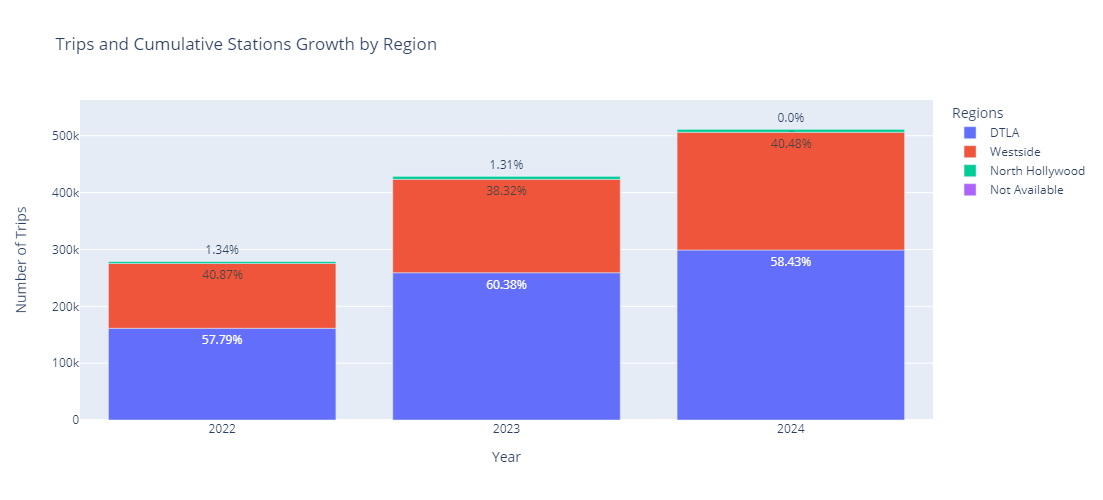

In [82]:
stacked_df = filtered_df.copy()
stacked_df["pct"] = stacked_df.groupby("year")["ntrips"].transform(lambda x: round(x*100 / x.sum(),2))
stacked_df["pct_text"] = (stacked_df["pct"]).astype(str) + "%"
stacked_df["year"] = stacked_df["year"].astype(str)
fig = px.bar(
    stacked_df, 
    x="year", 
    y="ntrips", 
    color="region", 
    text="pct_text",
    title="Stacked Bar Chart of Trips Colored By Regions",
    labels={
        "year": "Year",
        "ntrips": "Number of Trips",
        "region": "Regions"
    },
    custom_data=[
        "region", "pct"
    ]
)
fig.update_traces(
    hovertemplate =
        "Region: %{customdata[0]}<br>" +
        "Year: %{x}<br>"
        "Trips: %{y}<br>" +
        "Percentage: %{customdata[1]}%<br>" +
        "<extra></extra>"
)
fig.update_layout(
    width=700,
    height=500,
    title_text="Trips and Cumulative Stations Growth by Region",
    showlegend=True
)
max_val = max(stacked_df.groupby("year")["ntrips"].sum()) * 1.1 
fig.update_yaxes(range=[0, max_val])
fig.show()

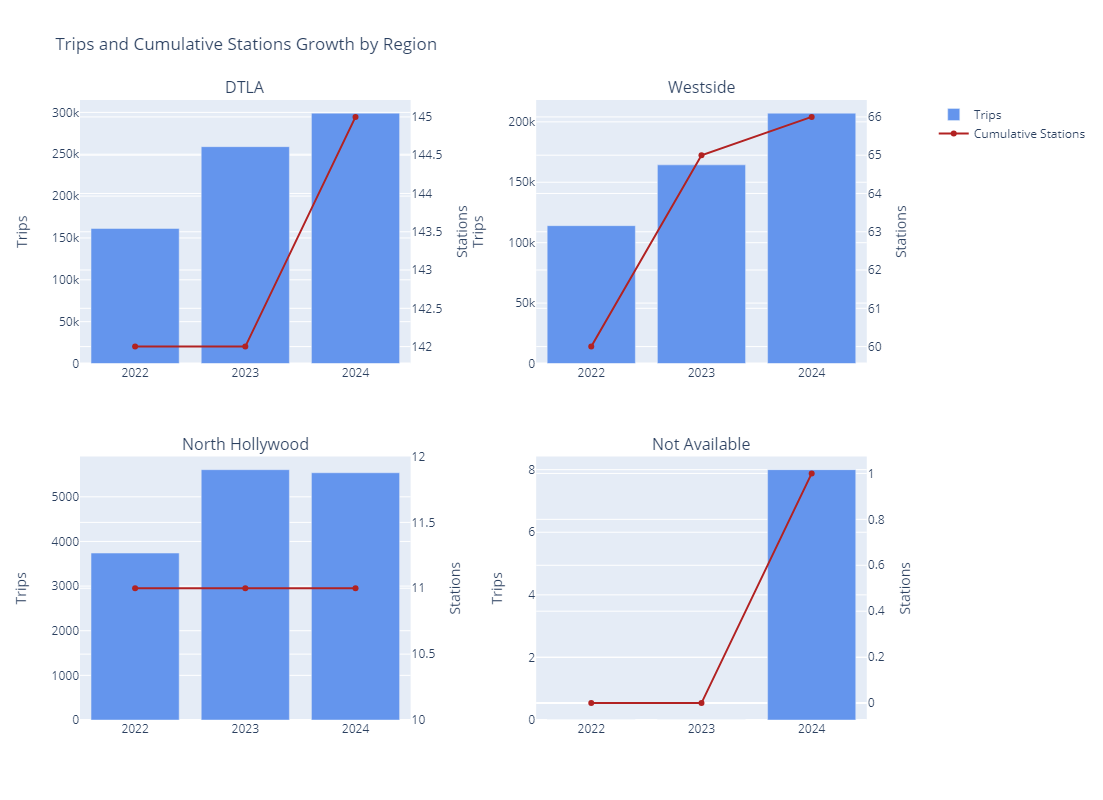

In [83]:
### Comparision Among Regions
fig = make_subplots(
    rows=2, cols=2, 
    subplot_titles=[f"{region}" for region in regions],
    specs=[[{"secondary_y": True} for idx in range(2)] for idx in range(2)],
    vertical_spacing=0.15,
    horizontal_spacing=0.15
)

for idx, region in enumerate(regions):
    ## Get data
    data_df = filtered_df[filtered_df["region"] == region]
    row=(idx//2)+1
    col=(idx%2)+1

    ## Number of trips
    fig.add_trace(
        go.Bar(
            x=data_df["year"].astype(str),
            y=data_df["ntrips"],
            marker_color="cornflowerblue",
            name="Trips",
            showlegend=(idx == 0),
            hovertemplate= f"Region: {region}<br>" + "Year: %{x}<br>"+ "Trips: %{y:,}<extra></extra>"
        ),
        row=row,
        col=col,
        secondary_y=False
    )

    ## Cumulative Stations
    fig.add_trace(
        go.Scatter(
            x=data_df["year"].astype(str),
            y=data_df["cumu_stations"],
            marker_color="firebrick",
            name="Cumulative Stations",
            showlegend=(idx == 0),
            hovertemplate= f"Region: {region}<br>" + "Year: %{x}<br>"+ "Stations: %{y:,}<extra></extra>"
        ),
        row=row,
        col=col,
        secondary_y=True
    )
    
fig.update_layout(
    height=800,
    title_text="Trips and Cumulative Stations Growth by Region",
    showlegend=True
)
fig.update_yaxes(title_text="Trips", secondary_y=False)
fig.update_yaxes(title_text="Stations", secondary_y=True)
fig.show()

#### 2.5 YoY Active Station Usage Changes

In [84]:
def get_yoyChange(conn):
    db_cursor = conn.cursor()
    db_cursor.execute(
        """
        WITH trips_by_year AS (
            SELECT
        		t.start_station,
        		s.name,
        		s.region,
        		s.latitude,
        		s.longitude,
        		s.live_date,
        		EXTRACT(YEAR FROM start_time) AS year,
        		COUNT(*) AS ntrips
        	FROM trips AS t
        	LEFT JOIN stations AS s
        		ON t.start_station = s.station_id
        	WHERE
        		s.status LIKE 'Active' AND 
        		(s.latitude IS NOT NULL AND s.longitude IS NOT NULL)
        	GROUP BY 
        		t.start_station, year
        ),
        pivot_year AS (
        	SELECT
        		start_station AS start_id,
                name,
                region,
                latitude,
                longitude,
                live_date,
                MAX(CASE WHEN year = 2022 THEN ntrips ELSE 0 END) AS trips_2022,
                MAX(CASE WHEN year = 2023 THEN ntrips ELSE 0 END) AS trips_2023,
                MAX(CASE WHEN year = 2024 THEN ntrips ELSE 0 END) AS trips_2024
        	FROM trips_by_year
            GROUP BY start_station
        ),
        yoy_change AS (
        	SELECT
        		*,
                trips_2023 - trips_2022 AS change_22_23,
                trips_2024 - trips_2023 AS change_23_24,
                ROUND(CASE WHEN trips_2022 > 0 THEN (trips_2023 - trips_2022) * 100.0 / trips_2022 END, 2) AS pct_22_23,
                ROUND(CASE WHEN trips_2023 > 0 THEN (trips_2024 - trips_2023) * 100.0 / trips_2023 END, 2) AS pct_23_24
            FROM pivot_year
        )
        
        SELECT *
        FROM yoy_change;
        """
    )
    rows = db_cursor.fetchall()
    db_cursor.close()
    yoychange = pd.DataFrame(
        rows, columns=[
            "start_id", "name", "region", "latitude", "longitude", "live_date",
            "trips_2022", "trips_2023", "trips_2024",
            "change_22_23", "change_23_24", "pct_22_23", "pct_23_24"
        ]
    )
    yoychange = yoychange.astype({"pct_22_23": float, "pct_23_24": float})
    return yoychange

In [85]:
yoy_change = get_yoyChange(db_conn)

In [86]:
yoy_change.head(5)

,start_id,name,region,latitude,longitude,live_date,trips_2022,trips_2023,trips_2024,change_22_23,change_23_24,pct_22_23,pct_23_24
0,3005,7th & Flower,DTLA,34.0485000,-118.2585370,2016-07-07,7514,12105,12087,4591,-18,61.10,-0.15
1,3006,Olive & 8th,DTLA,34.0455400,-118.2566680,2016-07-07,3931,7129,11370,3198,4241,81.35,59.49
2,3007,5th & Grand,DTLA,34.0504800,-118.2545930,2016-07-07,2305,3332,3164,1027,-168,44.56,-5.04
3,3008,Figueroa & 9th,DTLA,34.0466120,-118.2627330,2016-07-07,2212,3860,5003,1648,1143,74.50,29.61
4,3010,11th & Maple,DTLA,34.0370480,-118.2548680,2016-07-10,337,667,825,330,158,97.92,23.69


In [87]:
yoy_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   start_id      223 non-null    int64  
 1   name          223 non-null    object 
 2   region        223 non-null    object 
 3   latitude      223 non-null    object 
 4   longitude     223 non-null    object 
 5   live_date     223 non-null    object 
 6   trips_2022    223 non-null    int64  
 7   trips_2023    223 non-null    int64  
 8   trips_2024    223 non-null    int64  
 9   change_22_23  223 non-null    int64  
 10  change_23_24  223 non-null    int64  
 11  pct_22_23     212 non-null    float64
 12  pct_23_24     218 non-null    float64
dtypes: float64(2), int64(6), object(5)
memory usage: 22.8+ KB


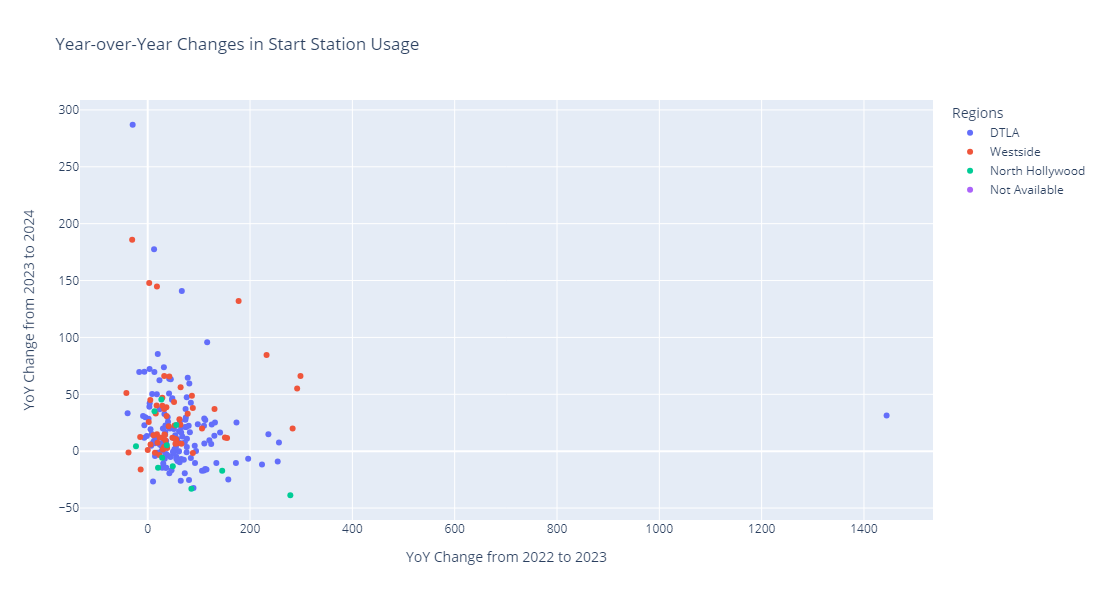

In [88]:
## Overall Trend for Active Stations
fig = px.scatter(
    yoy_change, 
    x="pct_22_23", 
    y="pct_23_24",
    color="region",
    title="Year-over-Year Changes in Start Station Usage",
    labels={
        "pct_22_23": "YoY Change from 2022 to 2023",
        "pct_23_24": "YoY Change from 2023 to 2024",
        "region": "Regions"
    },
    height=600, width=900,
    custom_data=[
        "start_id", "name", "region", "live_date", 
        "trips_2022", "trips_2023", "trips_2024"
    ]
)
fig.update_traces(
    hovertemplate =
        "<b>%{customdata[1]} (%{customdata[0]})</b><br>" +
        "Region: %{customdata[2]}<br>" +
        "Live Date: %{customdata[3]}<br>" +
        "Trips 2022: %{customdata[4]}<br>" +
        "Trips 2023: %{customdata[5]} (%{x:.0f}%)<br>" +
        "Trips 2024: %{customdata[6]} (%{y:.0f}%)<br>" +
        "<extra></extra>"
)
fig.show()

In [89]:
### Remove '7th & Westmoreland' to prevent it from skewed the overall plot
yoy_rm_outliers = yoy_change.copy()
yoy_rm_outliers = yoy_rm_outliers.drop(yoy_rm_outliers[yoy_rm_outliers["start_id"]==4628].index)

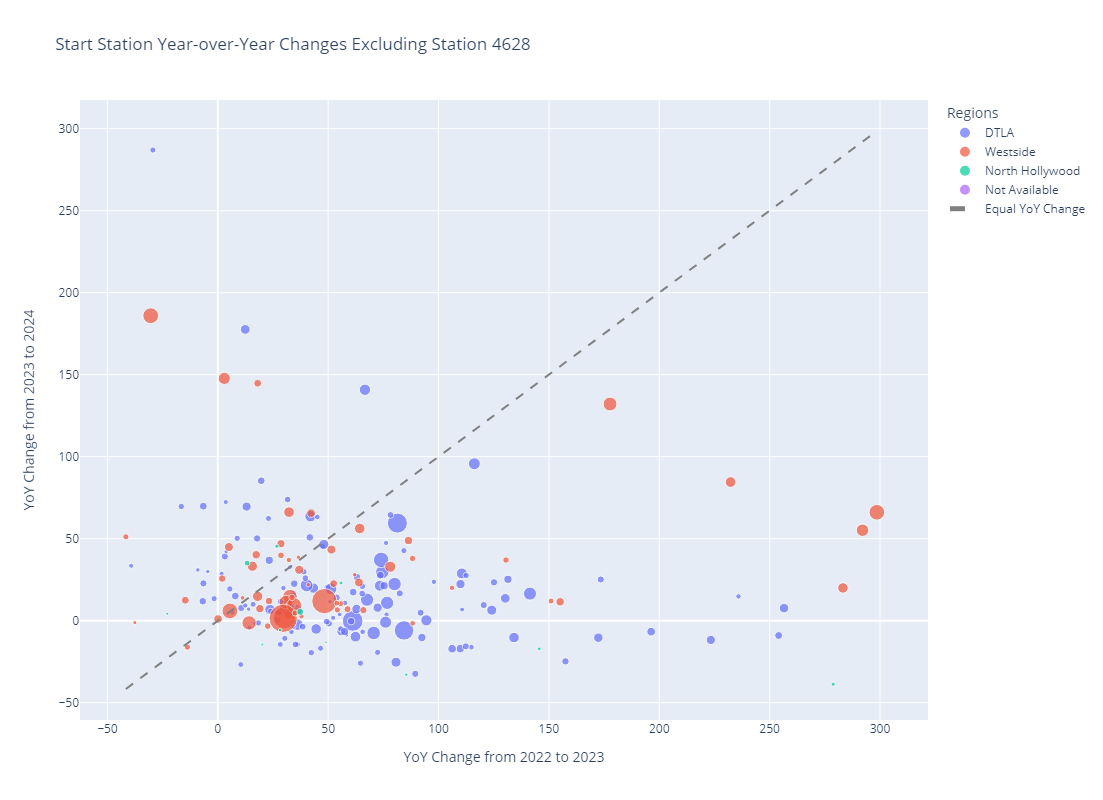

In [90]:
## Overall Trend for Active Stations
fig = px.scatter(
    yoy_rm_outliers, 
    x="pct_22_23", 
    y="pct_23_24",
    color="region",
    size="trips_2024",
    title="Start Station Year-over-Year Changes Excluding Station 4628",
    labels={
        "pct_22_23": "YoY Change from 2022 to 2023",
        "pct_23_24": "YoY Change from 2023 to 2024",
        "region": "Regions"
    },
    height=800, width=1000,
    custom_data=[
        "start_id", "name", "region", "live_date", 
        "trips_2022", "trips_2023", "trips_2024"
    ]
)
fig.update_traces(
    hovertemplate =
        "<b>%{customdata[1]} (%{customdata[0]})</b><br>" +
        "Region: %{customdata[2]}<br>" +
        "Live Date: %{customdata[3]}<br>" +
        "Trips 2022: %{customdata[4]}<br>" +
        "Trips 2023: %{customdata[5]} (%{x:.0f}%)<br>" +
        "Trips 2024: %{customdata[6]} (%{y:.0f}%)<br>" +
        "<extra></extra>"
)
## Add 45 degree diagonal line
min_val = min(yoy_rm_outliers["pct_22_23"].min(), yoy_rm_outliers["pct_23_24"].min())
max_val = max(yoy_rm_outliers["pct_22_23"].max(), yoy_rm_outliers["pct_23_24"].max())
fig.add_trace(go.Scatter(
    x=[min_val, max_val],
    y=[min_val, max_val],
    mode="lines",
    line=dict(color="grey", dash="dash"),
    name="Equal YoY Change"
))
fig.show()

In [91]:
db_conn.close()
print("Connected:", db_conn.is_connected())

Connected: False


### 3. Spatial Analysis Summary
* Downtown LA has a higher number of Metro Bike Share Stations, as demonstrated in the Power BI dashboard. The Westside area has stations with the highest number of active trips.
* The top three routes with the highest number of trips were made between Downtown Santa Monica E Line Station and Ocean Front Walk & Navy at an average of 27.58 minutes per trip. This is followed by Ocean Front Walk & North Venice and Ocean Front Walk & Navy at an average of 23.10 minutes per trip and Downtown Santa Monica E Line Station and Ocean Front Walk & Navy at an average of 34.84 minutes per trip.
* From the spatial analysis, we could determine that a high proportion of the trips between stations was done around the LA beach area compared to other areas. However, the overall usage trend in the Downtown area is higher than in the Westside.
* Evaluating the trip growth by region and a cumulative number of stations revealed that between 2022 and 2023, while the number of active stations is constant, the number of users increases. This signals the wider adoption of Metro Bike share. This is similar to North Hollywood's growth.
* The expansion into the Westside region has achieved relatively consistent growth compared to DTLA, where the growth was slightly lower between 2023 and 2024.